In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import scanpy as sc
import scipy as sp

import sys
import os
sys.path.append(os.path.abspath("./utility_functions"))

import rz_functions as rz
import ng_functions as ng
import rz_utility_spring as srz

from time import time
from seaborn import heatmap

import scrublet as scr


/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


python version: 3.6.10


# Data loading, preprocessing and normalization

In [2]:
adata = sc.read_h5ad('backups/tox_marie_all_cells_unnormalized_pca_umap_leiden_35358x22631_backup_200412_21h30.h5ad')

adata[:,['Il12b']].X = adata[:,['Il12b', 'eYFP']].X.sum(1)
adata[:,['eYFP']].X = 0


sc.pp.normalize_total(adata, target_sum=1e4)

adata.obs['n_counts'] = adata.X.sum(1).A1
adata.obs.head()

barcode group        library_name   marker  \
48-pool1   AAACAAACAGAGGATAAGACACCA     B  Liver_CD45pos_NT_B  CD45pos   
98-pool1   AAACAAACAGAGGATACAATACTT     B  Liver_CD45pos_NT_B  CD45pos   
237-pool1  AAACAAACAGAGGATAGGCCCTTA     B  Liver_CD45pos_NT_B  CD45pos   
246-pool1  AAACAAACAGAGGATAGGGAGGTA     B  Liver_CD45pos_NT_B  CD45pos   
342-pool1  AAACAAACAGAGGATATGGCTACC     B  Liver_CD45pos_NT_B  CD45pos   

           max_mt  min_tot  mito_frac      n_counts  n_genes   pool tissue  \
48-pool1     0.15      200   0.040964  10000.000977      348  pool1  Liver   
98-pool1     0.15      200   0.005613  10000.000000      581  pool1  Liver   
237-pool1    0.15      200   0.035451  10000.001953      470  pool1  Liver   
246-pool1    0.15      200   0.018000  10000.000000      374  pool1  Liver   
342-pool1    0.15      200   0.035088  10000.000000      318  pool1  Liver   

          treatment leiden  
48-pool1         NT      8  
98-pool1         NT     20  
237-pool1        NT     11  
246-pool1        NT     16  
342-pool1        NT      6

In [3]:
#loglikelihoods = sp.sparse.load_npz('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz')
logls = np.load('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz', allow_pickle=True)

mostlikely_subset = pd.DataFrame(logls['data'], index=logls['index'], columns=logls['columns']).idxmax()
mostlikely_subset = pd.Series(mostlikely_subset, dtype='category')
mostlikely_subset.index = adata.obs.index

mostlikely_celltype = mostlikely_subset.map(ng.cell_subset_dict).astype('category')

In [4]:
adata.obs['cell_type'] = mostlikely_celltype
adata.obs['minor_subset'] = mostlikely_subset

#annotate color palette in adata.uns
adata.uns['cell_type_colors'] = adata.obs['cell_type'].cat.categories.map(ng.cell_type_cmap).tolist()
adata.uns['minor_subset_colors'] = adata.obs['minor_subset'].cat.categories.map(ng.cell_subset_cmap).tolist()

[<Figure size 10305x2000 with 3 Axes>]

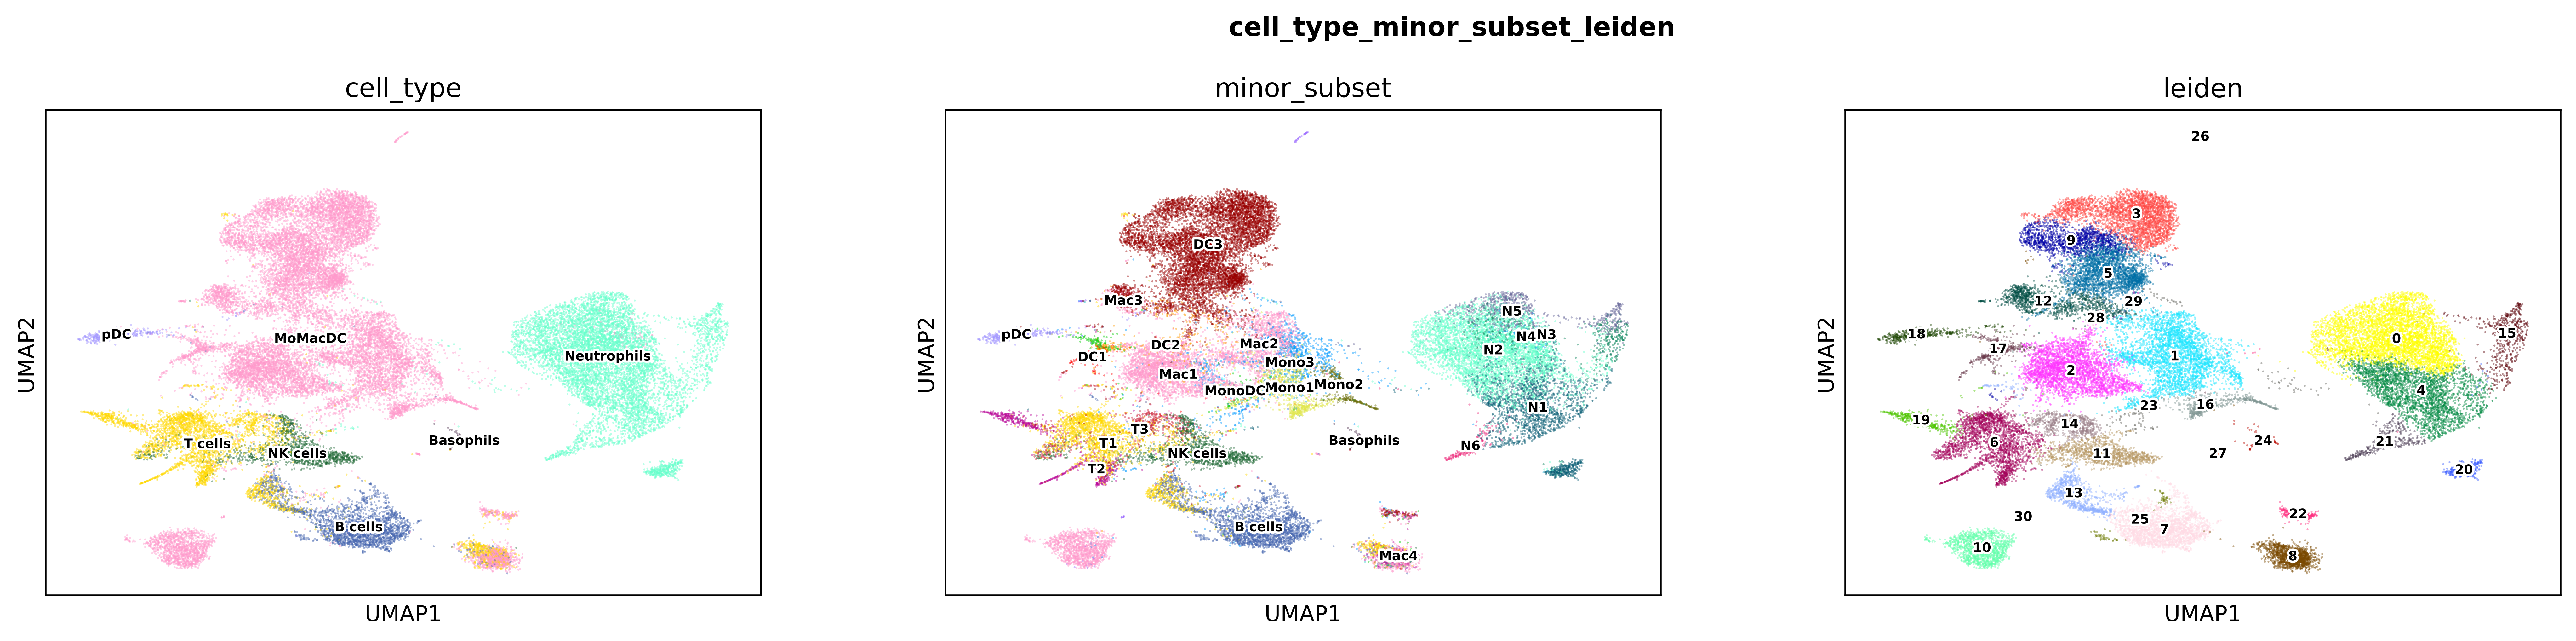

In [5]:
ng.umap_plot(adata, color=['cell_type', 'minor_subset', 'leiden'], return_fig=True, save_fig=False, alpha=0.5)

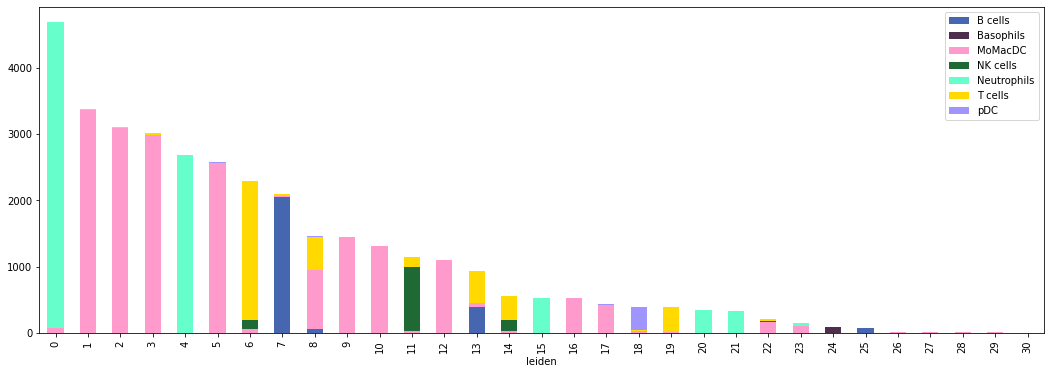

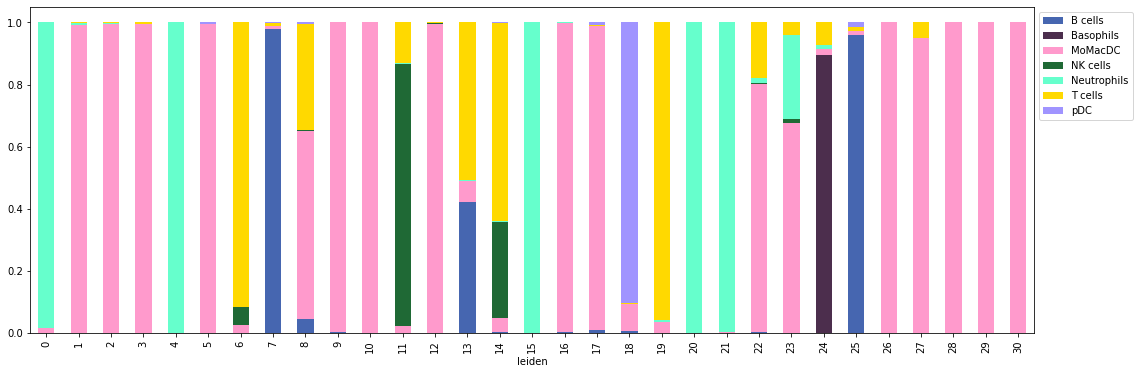

In [7]:
leiden_cell_type_counts = adata.obs.groupby('leiden').cell_type.value_counts().to_frame(name='count').reset_index().pivot(index='leiden',columns='cell_type', values='count')
leiden_cell_type_percentages = leiden_cell_type_counts.div(leiden_cell_type_counts.sum(axis=1), axis=0)
#


leiden_cell_type_counts.plot.bar(width=0.5, stacked=True, color=ng.cell_type_cmap.values())
plt.gcf().set_size_inches(18,6)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

leiden_cell_type_percentages.plot.bar(width=0.5, stacked=True, color=ng.cell_type_cmap.values())
plt.gcf().set_size_inches(18,6)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

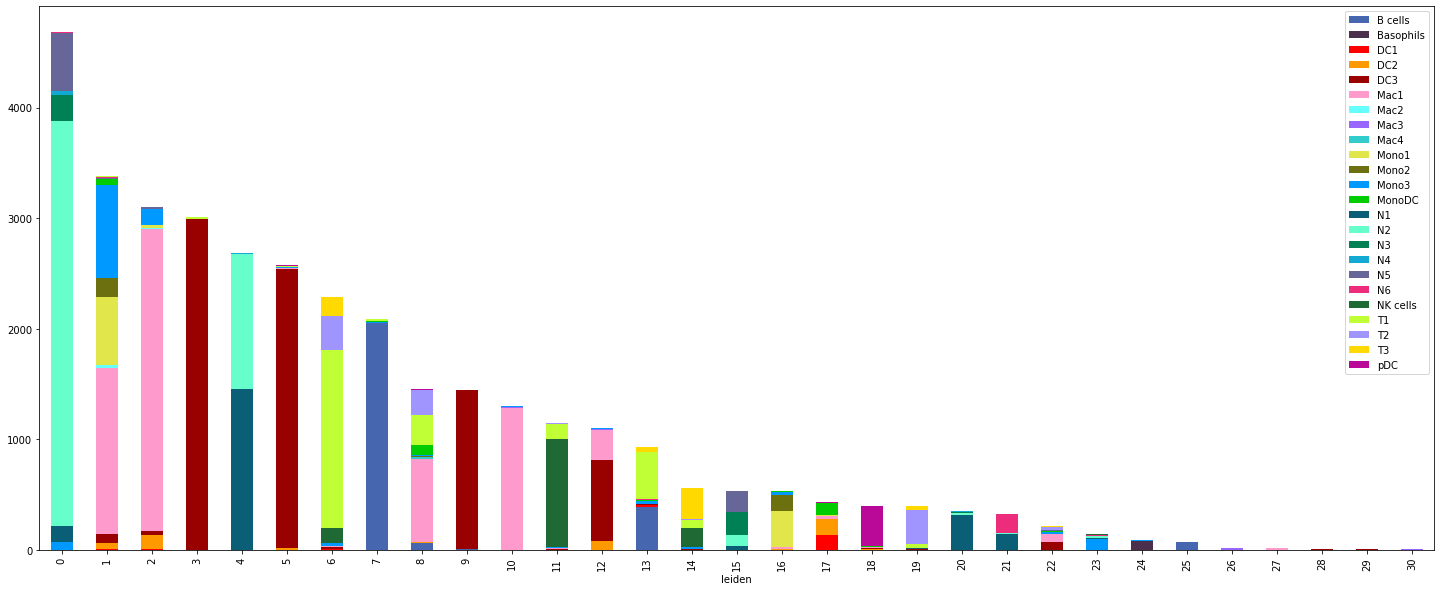

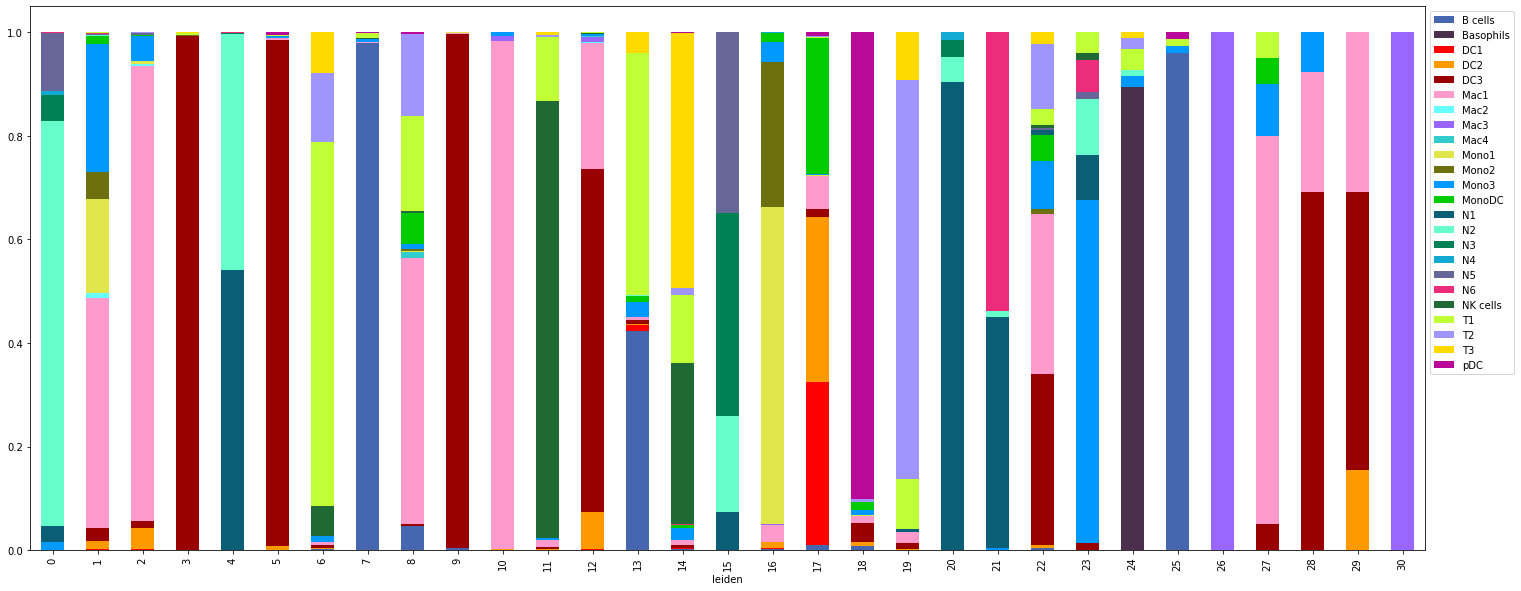

In [8]:
leiden_cell_subset_counts = adata.obs.groupby('leiden').minor_subset.value_counts().to_frame(name='count').reset_index().pivot(index='leiden',columns='minor_subset', values='count')
leiden_cell_subset_percentages = leiden_cell_subset_counts.div(leiden_cell_subset_counts.sum(axis=1), axis=0)

leiden_cell_subset_counts.plot.bar(width=0.5, stacked=True, color=ng.cell_subset_cmap.values())
plt.gcf().set_size_inches(25,10)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

leiden_cell_subset_percentages.plot.bar(width=0.5, stacked=True, color=ng.cell_subset_cmap.values())
plt.gcf().set_size_inches(25,10)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [9]:
cluster_to_subset = dict(adata.obs.groupby('leiden').minor_subset.value_counts().to_frame(name='count').reset_index().pivot(index='leiden',columns='minor_subset', values='count').idxmax(1))

adata.obs['leiden_minor_subset'] = adata.obs.leiden.map(cluster_to_subset).astype('category')
adata.obs['leiden_cell_type'] = adata.obs.leiden_minor_subset.map(ng.cell_subset_dict).astype('category')

adata.obs

barcode   group           library_name  \
48-pool1       AAACAAACAGAGGATAAGACACCA       B     Liver_CD45pos_NT_B   
98-pool1       AAACAAACAGAGGATACAATACTT       B     Liver_CD45pos_NT_B   
237-pool1      AAACAAACAGAGGATAGGCCCTTA       B     Liver_CD45pos_NT_B   
246-pool1      AAACAAACAGAGGATAGGGAGGTA       B     Liver_CD45pos_NT_B   
342-pool1      AAACAAACAGAGGATATGGCTACC       B     Liver_CD45pos_NT_B   
...                                 ...     ...                    ...   
1471700-pool5  TGTTATCAAGGCTTAGGATTTACC  J_rep2  Liver_IL12_Trx_J_rep2   
1471869-pool5  TGTTATCAAGGCTTAGTTTATCAC  J_rep2  Liver_IL12_Trx_J_rep2   
1472549-pool5  TGTTATCAATTAGACGTACTTGTG       K       Liver_IL12_Trx_K   
1472953-pool5  TGTTATCACGGAGAGATCCTTATT  I_rep2  Tumor_IL12_Trx_I_rep2   
1472972-pool5  TGTTATCACGGAGAGATGATGCCC  I_rep2  Tumor_IL12_Trx_I_rep2   

                marker  max_mt  min_tot  mito_frac      n_counts  n_genes  \
48-pool1       CD45pos    0.15      200   0.040964  10000.000977      348   
98-pool1       CD45pos    0.15      200   0.005613  10000.000000      581   
237-pool1      CD45pos    0.15      200   0.035451  10000.001953      470   
246-pool1      CD45pos    0.15      200   0.018000  10000.000000      374   
342-pool1      CD45pos    0.15      200   0.035088  10000.000000      318   
...                ...     ...      ...        ...           ...      ...   
1471700-pool5     IL12    0.15      250   0.050179  10000.000000      215   
1471869-pool5     IL12    0.15      250   0.043726  10000.000000      550   
1472549-pool5     IL12    0.15      400   0.023161  10000.000977      438   
1472953-pool5     IL12    0.15      300   0.022010   9999.999023      785   
1472972-pool5     IL12    0.15      300   0.040307  10000.000977      631   

                pool tissue treatment leiden    cell_type minor_subset  \
48-pool1       pool1  Liver        NT      8      MoMacDC         Mac1   
98-pool1       pool1  Liver        NT     20  Neutrophils           N1   
237-pool1      pool1  Liver        NT     11     NK cells     NK cells   
246-pool1      pool1  Liver        NT     16      MoMacDC        Mono2   
342-pool1      pool1  Liver        NT      6      T cells           T1   
...              ...    ...       ...    ...          ...          ...   
1471700-pool5  pool5  Liver       Trx      5      MoMacDC          DC3   
1471869-pool5  pool5  Liver       Trx      5      MoMacDC          DC3   
1472549-pool5  pool5  Liver       Trx      3      MoMacDC          DC3   
1472953-pool5  pool5  Tumor       Trx      3      MoMacDC          DC3   
1472972-pool5  pool5  Tumor       Trx      2      MoMacDC         Mac1   

              leiden_minor_subset leiden_cell_type  
48-pool1                     Mac1          MoMacDC  
98-pool1                       N1      Neutrophils  
237-pool1                NK cells         NK cells  
246-pool1                   Mono1          MoMacDC  
342-pool1                      T1          T cells  
...                           ...              ...  
1471700-pool5                 DC3          MoMacDC  
1471869-pool5                 DC3          MoMacDC  
1472549-pool5                 DC3          MoMacDC  
1472953-pool5                 DC3          MoMacDC  
1472972-pool5                Mac1          MoMacDC  

[35358 rows x 17 columns]

In [10]:
cat0 = rz.centroids('leiden_minor_subset', adata).T
cat0.head()

Mac1        N1  NK cells     Mono1        T1       DC3        N2  \
Xkr4    0.000718  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Rp1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Sox17   0.130904  0.003033  0.000000  0.000000  0.011436  0.010678  0.003508   
Mrpl15  0.564867  0.008692  0.338037  0.457451  0.877519  0.464694  0.055570   
Lypla1  0.468950  0.282648  0.658263  0.571524  0.566027  0.590629  0.305817   

         B cells       DC2        N3        T2        T3        N6       pDC  \
Xkr4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Rp1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Sox17   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Mrpl15  0.615799  0.519847  0.042503  0.511604  0.867207  0.068294  0.618968   
Lypla1  0.379309  0.356524  0.123772  0.936461  0.492958  0.262048  0.362601   

        Basophils     Mono3      Mac3  
Xkr4     0.000000  0.000000  0.000000  
Rp1      0.000000  0.000000  0.000000  
Sox17    0.000000  0.000000  0.000000  
Mrpl15   0.355680  0.270379  0.000000  
Lypla1   0.863147  0.713476  0.369508

In [11]:
pseudo = 0.1
cat = cat0 + pseudo

# Load reference expression profiles in an AnnData object compatible with scanpy¶

In [12]:
prepath = 'Zilionis_Immunity_2019/'
# load count data
rzdata = sc.read_mtx(prepath+'GSE127465_mouse_counts_normalized_15939x28205.mtx.gz')

# load cell annotations
rzdata.obs = pd.read_csv(prepath+'GSE127465_mouse_cell_metadata_15939x12.tsv.gz',
            sep='\t',comment='#')

# load gene names
rzdata.var_names = np.loadtxt(prepath+'GSE127465_gene_names_mouse_28205.tsv.gz',dtype=str)
rzdata.var_names_make_unique()

#normalize immunity paper data to 10,000 counts per cell
sc.pp.normalize_per_cell(rzdata,counts_per_cell_after=1e4)

print(rzdata.shape)
rzdata.obs.head()

Transforming to str index.


(15939, 28205)


Tumor or healthy Biological replicate Library Barcode Library prep batch  \
0                t      Tumor-bearing 1   t_1_1  bc0001    round1_20151128   
1                t      Tumor-bearing 1   t_1_1  bc0002    round1_20151128   
2                t      Tumor-bearing 1   t_1_1  bc0003    round1_20151128   
3                t      Tumor-bearing 1   t_1_1  bc0004    round1_20151128   
4                t      Tumor-bearing 1   t_1_1  bc0005    round1_20151128   

   Total counts  Percent counts from mitochondrial genes  \
0        7927.0                                    3.393   
1        5665.0                                    6.461   
2        4615.0                                    2.579   
3        5353.0                                    3.082   
4        4653.0                                    2.901   

  Most likely Immgen cell type Major cell type Minor subset            x  \
0        MF_Thio5_II+480int_PC         MoMacDC         Mac1  1174.120533   
1            DC_103-11b+24+_Lu         MoMacDC          DC1  1068.808968   
2              DC_8-4-11b+_SLN         MoMacDC          DC3   791.206113   
3                     DC_8+_Th         MoMacDC          DC1  1068.688851   
4              DC_8-4-11b+_SLN         MoMacDC          DC3   805.516538   

            y     n_counts  
0 -217.075559  2434.620605  
1  -37.966851  2434.620361  
2  -51.756695  2434.620117  
3  -17.459386  2434.620361  
4  -52.706709  2434.620117

# Find common genes between the two datasets.
 Filtering on variable genes is also a possibility but I start by simply using all genes

In [13]:
Eraw = rzdata.X
print(type(Eraw))

gene_list = rzdata.var_names

<class 'scipy.sparse.csr.csr_matrix'>


In [14]:
# common genes
gmask = np.in1d(gene_list, cat.index)

# genes detected in the current dataset:
m2 = np.array(Eraw.sum(axis=0))[0]>0

# combine masks
gmask = gmask&m2


common_genes = gene_list[gmask]
print(len(gene_list),len(cat.index),len(common_genes))

28205 22631 20075


In [15]:
print(Eraw.shape)

(15939, 28205)


In [16]:
start = time()
bays = []
i = 0
step=5000
comment = 'zilionis_classified_on_leiden_clusters'
for j in range(step,Eraw.shape[0]+step,step):
    
    # Eraw - sparse cells x gene matrix
    j = min(j,Eraw.shape[0])
    tmp_dense = pd.DataFrame(Eraw.T[gmask][:,i:j].todense())
    tmp_dense.index = np.array(gene_list)[gmask]
    
    bay = rz.bayesian_classifier(tmp_dense,cat.loc[common_genes])
    bays.append(bay)
    i0 = i
    i = j
    
    print('%.2f min.'%((time()-start)/60.))
    print('cells from %d to %d done'%(i0,j))

# conenate
bay = pd.concat(bays,axis=1)

# reset index
bay.columns = np.arange(bay.shape[1])

fname = 'backups/loglikelihoods_bay_classif_%s_%s'%(comment,rz.now())
print(fname)
rz.save_df(bay,fname)

1.33 min.
cells from 0 to 5000 done
3.18 min.
cells from 5000 to 10000 done
5.82 min.
cells from 10000 to 15000 done
6.33 min.
cells from 15000 to 15939 done
backups/loglikelihoods_bay_classif_zilionis_classified_on_leiden_clusters_200415_02h57


# Load classifier log-likelihoods, distinguish from Lung --> Tox

In [17]:
logls_lung = np.load('backups/loglikelihoods_bay_classif_zilionis_classified_on_leiden_clusters_200413_17h48.npz', allow_pickle=True)

mostlikely_subset_lung = pd.DataFrame(logls_lung['data'], index=logls_lung['index'], columns=logls_lung['columns']).idxmax()
mostlikely_subset_lung = pd.Series(mostlikely_subset_lung, dtype='category')
mostlikely_subset_lung.index = rzdata.obs.index

mostlikely_celltype_lung = mostlikely_subset_lung.map(ng.cell_subset_dict).astype('category')

rzdata.obs['leiden_cell_type'] = mostlikely_celltype_lung
rzdata.obs['leiden_minor_subset'] = mostlikely_subset_lung

In [18]:
rzdata.obs

Tumor or healthy Biological replicate Library Barcode  \
0                    t      Tumor-bearing 1   t_1_1  bc0001   
1                    t      Tumor-bearing 1   t_1_1  bc0002   
2                    t      Tumor-bearing 1   t_1_1  bc0003   
3                    t      Tumor-bearing 1   t_1_1  bc0004   
4                    t      Tumor-bearing 1   t_1_1  bc0005   
...                ...                  ...     ...     ...   
15934                t      Tumor-bearing 2   t_2_4  bc1083   
15935                t      Tumor-bearing 2   t_2_4  bc1084   
15936                t      Tumor-bearing 2   t_2_4  bc1085   
15937                t      Tumor-bearing 2   t_2_4  bc1086   
15938                t      Tumor-bearing 2   t_2_4  bc1088   

      Library prep batch  Total counts  \
0        round1_20151128        7927.0   
1        round1_20151128        5665.0   
2        round1_20151128        4615.0   
3        round1_20151128        5353.0   
4        round1_20151128        4653.0   
...                  ...           ...   
15934    round3_20160313        1082.0   
15935    round3_20160313         912.0   
15936    round3_20160313         926.0   
15937    round3_20160313         795.0   
15938    round3_20160313         661.0   

       Percent counts from mitochondrial genes Most likely Immgen cell type  \
0                                     3.393000        MF_Thio5_II+480int_PC   
1                                     6.461000            DC_103-11b+24+_Lu   
2                                     2.579000              DC_8-4-11b+_SLN   
3                                     3.082000                     DC_8+_Th   
4                                     2.901000              DC_8-4-11b+_SLN   
...                                        ...                          ...   
15934                                 6.561922                T_8Nve_Sp_OT1   
15935                                 3.837719                      B_Fo_Sp   
15936                                 5.507559                   GN_UrAc_PC   
15937                                 0.628931                 GN_Arth_SynF   
15938                                 8.018154                     B_Fo_MLN   

      Major cell type Minor subset            x           y     n_counts  \
0             MoMacDC         Mac1  1174.120533 -217.075559  2434.620605   
1             MoMacDC          DC1  1068.808968  -37.966851  2434.620361   
2             MoMacDC          DC3   791.206113  -51.756695  2434.620117   
3             MoMacDC          DC1  1068.688851  -17.459386  2434.620361   
4             MoMacDC          DC3   805.516538  -52.706709  2434.620117   
...               ...          ...          ...         ...          ...   
15934         T cells           T1   722.864953  622.365393  2434.620361   
15935         B cells      B cells   240.758904  292.600115  2434.620605   
15936     Neutrophils           N4  1037.348649 -796.034347  2434.620361   
15937     Neutrophils           N3   413.387190 -650.431908  2434.620605   
15938         B cells      B cells   208.024524  298.377909  2434.620850   

      leiden_cell_type leiden_minor_subset  
0              MoMacDC                Mac1  
1              MoMacDC                 DC2  
2              MoMacDC                 DC3  
3              MoMacDC                 DC2  
4              MoMacDC                 DC3  
...                ...                 ...  
15934          T cells                  T1  
15935          B cells             B cells  
15936          MoMacDC               Mono3  
15937      Neutrophils                  N1  
15938          B cells             B cells  

[15939 rows x 15 columns]

# Major cell type level

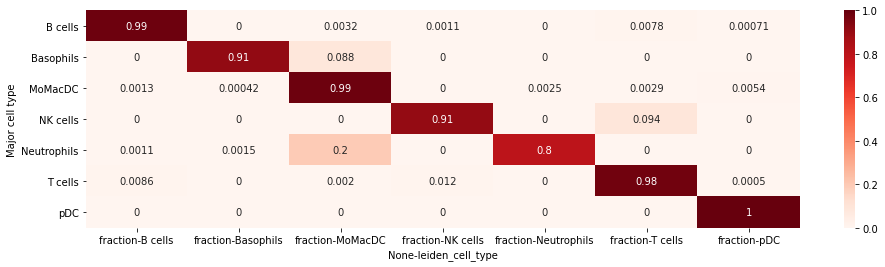

In [19]:
rz_to_tox_cell_type = rzdata.obs.groupby(['Major cell type', 'leiden_cell_type']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(index='Major cell type', columns='leiden_cell_type')

plt.figure(figsize=(16,4))
heatmap(rz_to_tox_cell_type, annot=True, cmap='Reds')

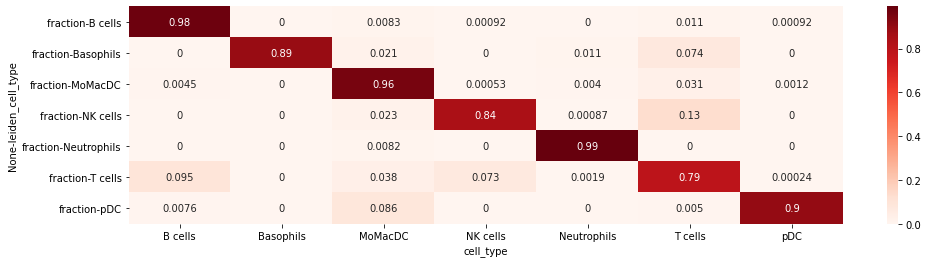

In [20]:
tox_to_rz_cell_type = adata.obs.groupby(['leiden_cell_type', 'cell_type']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(columns='leiden_cell_type', index='cell_type')

plt.figure(figsize=(16,4))

#transpose to keep direction of axes and still make it multiplicable
heatmap(tox_to_rz_cell_type.transpose(), annot=True, cmap='Reds')

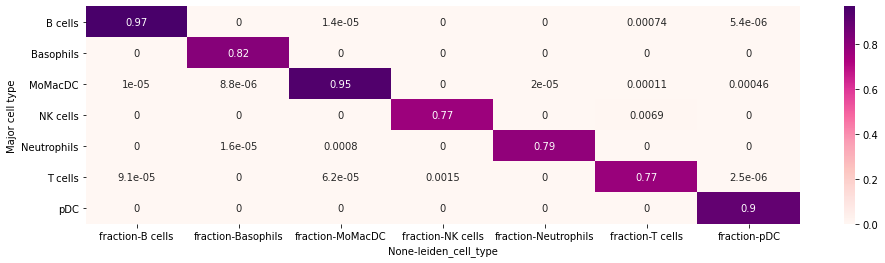

In [21]:
reciprocal_cell_type = rz_to_tox_cell_type * tox_to_rz_cell_type

plt.figure(figsize=(16,4))
heatmap(reciprocal_cell_type, annot=True, cmap='RdPu')


# Minor subset level

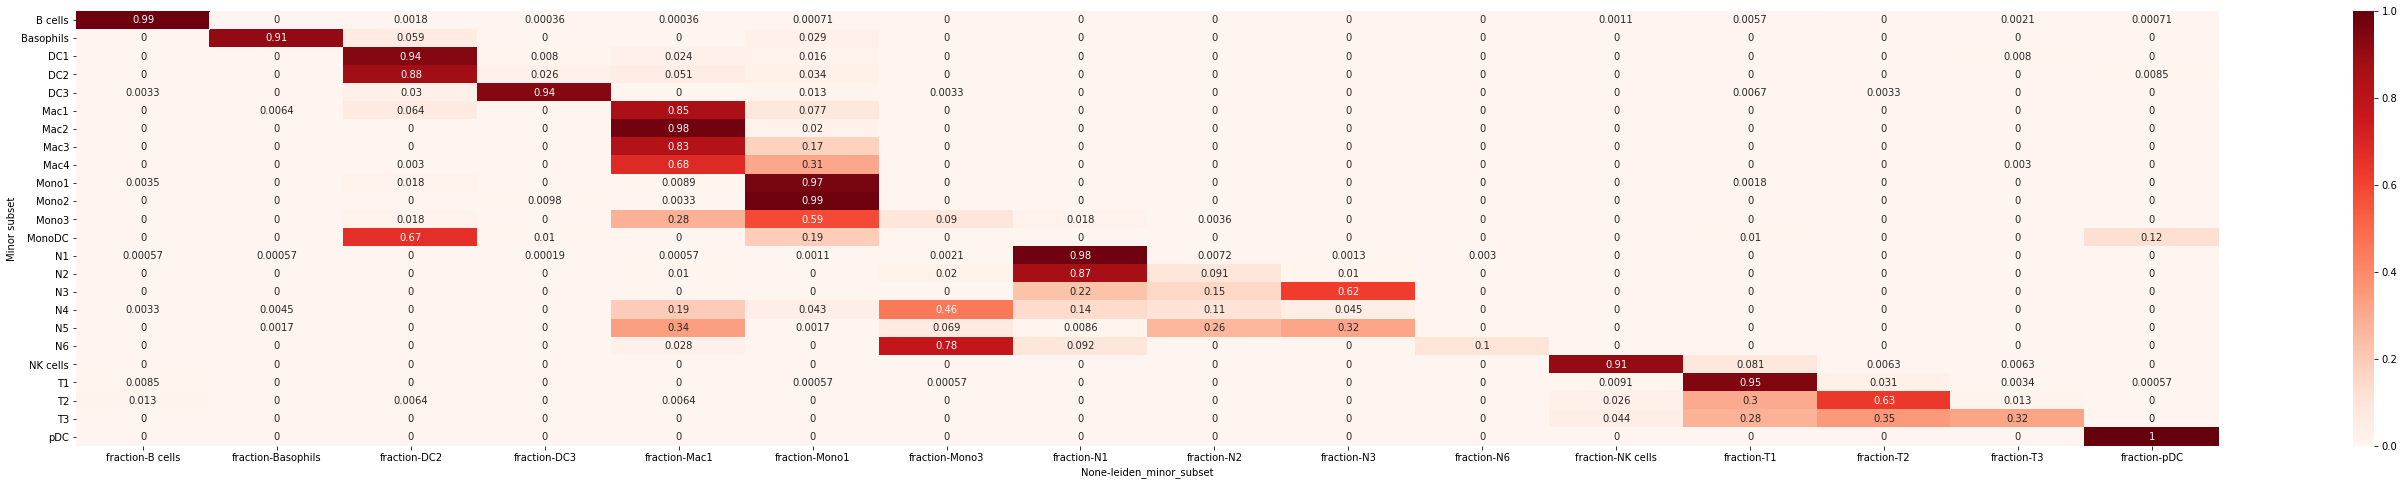

In [22]:
rz_to_tox_subset = rzdata.obs.groupby(['Minor subset', 'leiden_minor_subset']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(index='Minor subset', columns='leiden_minor_subset')

plt.figure(figsize=(48,8))
heatmap(rz_to_tox_subset, annot=True, cmap='Reds')

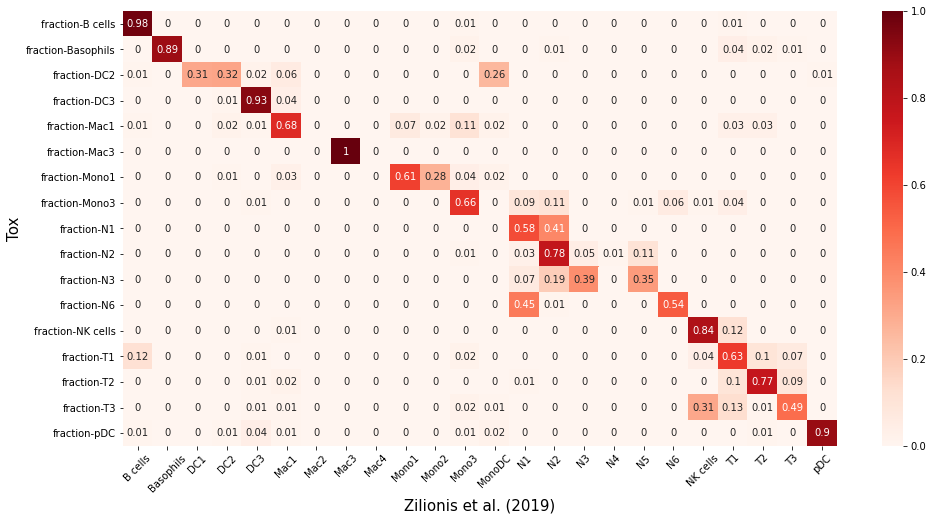

In [27]:
tox_to_rz_subset = adata.obs.groupby(['leiden_minor_subset', 'minor_subset']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(columns='leiden_minor_subset', index='minor_subset')

plt.figure(figsize=(16,8))
heatmap(round(tox_to_rz_subset.transpose(),2), annot=True, cmap='Reds')

plt.xlabel('Zilionis et al. (2019)', fontsize=15)
plt.ylabel('Tox', fontsize=15)
plt.xticks(rotation=45)


plt.show()

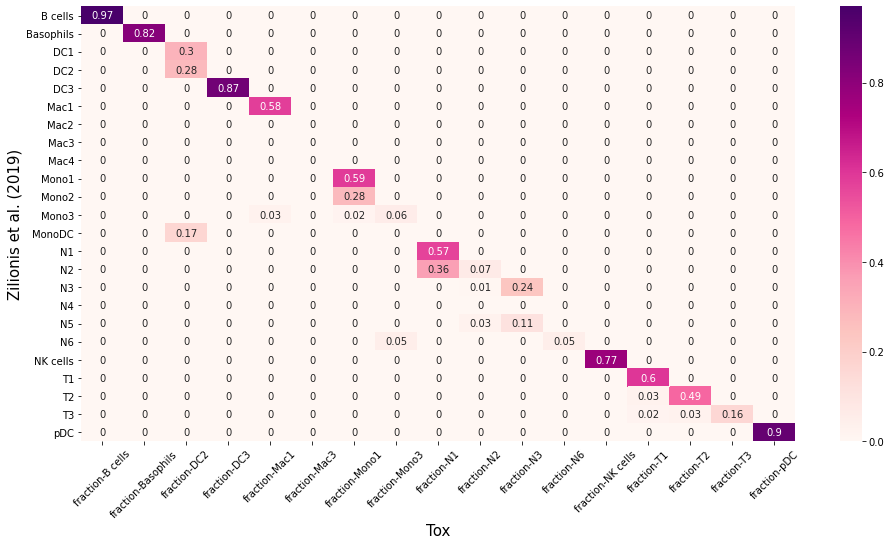

In [26]:
reciprocal_subset = rz_to_tox_subset * tox_to_rz_subset

plt.figure(figsize=(16,8))
heatmap(round(reciprocal_subset.fillna(0),2), annot=True, cmap='RdPu')

plt.ylabel('Zilionis et al. (2019)', fontsize=15)
plt.xlabel('Tox', fontsize=15)
plt.xticks(rotation=45)

plt.show()
